**<font color='red'>T</font>**hermodynamically Optimal Locally Int**<font color='red'>ERP</font>**retable Explanations **(<font color='red'>TERP</font>)**



---


<img src="https://raw.githubusercontent.com/shams-mehdi/TERP/main/terp2.jpg">

**Explain VAMPnets predictions trained on alanine dipeptide in vacuum**


---
<img src="https://raw.githubusercontent.com/shams-mehdi/TERP/main/203.png">

In [ ]:
#@title Step 1: Download and install necessary packages (VAMPnets, PyEMMA)
!apt remove cmake
!pip install cmake --upgrade

!pip install deeptime --verbose
!pip install mdshare --verbose
!pip install pyemma --verbose

Streaming output truncated to the last 5000 lines.
    Found link https://files.pythonhosted.org/packages/88/c7/9f6270a2b68a9e2be1f1e732eff9a1b12f230f5ec8e55a20bfd1b24580a0/Cython-0.21.tar.gz#sha256=0cd5787fb3f1eaf8326b21bdfcb90aabd3eca7c214c5b7b503fbb82da97bbaa0 (from https://pypi.org/simple/cython/), version: 0.21
    Found link https://files.pythonhosted.org/packages/7c/5a/0d09e52dba06da0f973c586f0807bf56257479da7c862a7d969c894622bd/Cython-0.21.zip#sha256=30e334bf693de957026576b57d3c166b0a2da59e8060dde66970e80ea06fd446 (from https://pypi.org/simple/cython/), version: 0.21
    Skipping link: none of the wheel's tags (cp26-cp26mu-manylinux1_x86_64) are compatible (run pip debug --verbose to show compatible tags): https://files.pythonhosted.org/packages/73/fb/ddda557b5f632876fd28a6309295fd820f941965eea32df288dfd8ef6df9/Cython-0.21.1-cp26-cp26mu-manylinux1_x86_64.whl#sha256=b76cc74e77909e8eb757a90f8d4f13f018fbf20a81fff2cde1c99ff27fa85419 (from https://pypi.org/simple/cython/)
    Skippi

In [ ]:
!pip install mdshare

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached mdshare-0.4.2.tar.gz (18 kB)
  Using cached mdshare-0.4.1.tar.gz (17 kB)
  Using cached mdshare-0.4.0.tar.gz (16 kB)
  Using cached mdshare-0.3.2.tar.gz (9.5 kB)
  Using cached mdshare-0.3.1.tar.gz (9.1 kB)
  Using cached mdshare-0.3.0.tar.gz (8.9 kB)
  Using cached mdshare-0.2.1.tar.gz (7.7 kB)
  Using cached mdshare-0.2.0.tar.gz (7.8 kB)
  Using cached mdshare-0.1.0.tar.gz (15 kB)
ERROR: Could not find a version that satisfies the requirement mdshare (from versions: 0.1.0, 0.2.0, 0.2.1, 0.3.0, 0.3.1, 0.3.2, 0.4.0, 0.4.1, 0.4.2)
ERROR: No matching distribution found for mdshare


In [ ]:
#@title Step 2: Fetch alanine dipeptide trajectory data
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
#import mdshare  # for trajectory data
import pyemma
from tqdm.notebook import tqdm  # progress bar

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device {device}")

!npx degit shams-mehdi/SPIB-plumed-masterclass-2022 -f
dihedrals = np.load('aladip_inputs/aladip_unbiased_trajectory.npy')#[:500000,:]

traj = np.zeros((dihedrals.shape[0], 8))
for i in range(4):
  traj[:, 2*i] = np.sin(dihedrals[:,i])
  traj[:, 2*i+1] = np.cos(dihedrals[:,i])

Using device cuda
npx: installed 1 in 1.667s
> destination directory is not empty. Using --force, continuing
> cloned shams-mehdi/SPIB-plumed-masterclass-2022#HEAD


Print VAMPnets architechture (edit if needed), lagtime units: 0.05 ps

In [ ]:
#@title Step 3: Select VAMPnets parameters
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset
from deeptime.util.data import TrajectoryDataset
K =  3#@param {type:"integer"}
lagtime_set = 1 #@param {type:"integer"}
learning_rate = 0.0005 #@param {type:"number"}

dataset = TrajectoryDataset(lagtime_set, traj.astype(np.float32))
train_data = dataset
#train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])
lobe = nn.Sequential(
    nn.BatchNorm1d(traj.shape[1]),
    nn.Linear(traj.shape[1], 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 6), nn.ELU(),
    nn.Linear(6, K), nn.ELU(), 
    nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
)
from copy import deepcopy
lobe_timelagged = deepcopy(lobe).to(device=device)
lobe = lobe.to(device=device)
print(lobe)

Sequential(
  (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=8, out_features=20, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=20, out_features=20, bias=True)
  (6): ELU(alpha=1.0)
  (7): Linear(in_features=20, out_features=20, bias=True)
  (8): ELU(alpha=1.0)
  (9): Linear(in_features=20, out_features=20, bias=True)
  (10): ELU(alpha=1.0)
  (11): Linear(in_features=20, out_features=20, bias=True)
  (12): ELU(alpha=1.0)
  (13): Linear(in_features=20, out_features=20, bias=True)
  (14): ELU(alpha=1.0)
  (15): Linear(in_features=20, out_features=20, bias=True)
  (16): ELU(alpha=1.0)
  (17): Linear(in_features=20, out_features=6, bias=True)
  (18): ELU(alpha=1.0)
  (19): Linear(in_features=6, out_features=3, bias=True)
  (20): ELU(alpha=1.0)
  (21): Softmax(dim=1)
)


In [ ]:
print(traj.shape)

(2000000, 8)


In [ ]:
#@title Step 4: Train VAMPnets model
from deeptime.decomposition.deep import VAMPNet
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

vampnet = VAMPNet(lobe=lobe, lobe_timelagged=lobe_timelagged, learning_rate=learning_rate, device=device)
loader_train = DataLoader(train_data, batch_size=5000, shuffle=True)
#loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
model = vampnet.fit(loader_train, n_epochs=50, progress=tqdm).fetch_model()

#model = vampnet.fit(loader_train, n_epochs=30,
                    #validation_loader=loader_val, progress=tqdm).fetch_model()

VAMPNet epoch:   0%|          | 0/50 [00:00<?, ?it/s]

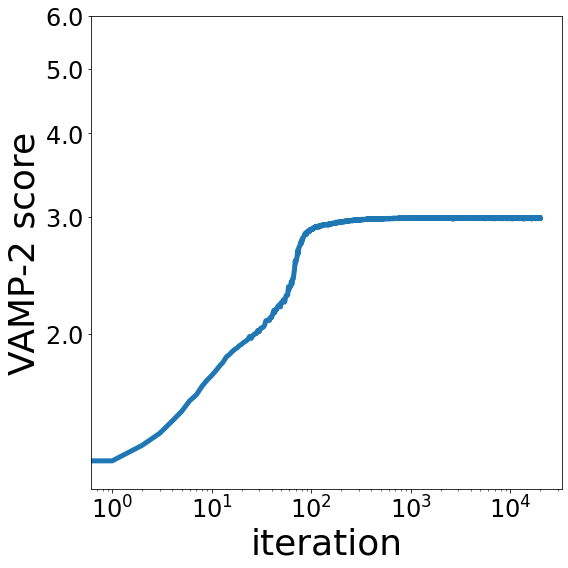

In [ ]:
#@title Step 5: Plot VAMP-2 score for training
fig, ax = plt.subplots(figsize = (8,8))
ax.loglog(*vampnet.train_scores.T, label='vampnet training score', linewidth = 5)
#ax.loglog(*vampnet.validation_scores.T, label='vampnet validation score', linewidth = 5)
ax.set_xlabel('iteration', fontsize = 36)
ax.set_ylabel('VAMP-2 score', fontsize = 36)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
#ax.legend(bbox_to_anchor=(0.75, 0.25), prop={'size': 24})
#ax.legend(loc = 'best', prop={'size': 24})
yticks = [2, 3, 4, 5, 6]
ax.set_yticks(yticks)
ax.set_yticklabels(["$%.1f$" % y for y in yticks], fontsize=24)

fig.tight_layout()

In [ ]:
#@title Step 6: Save VAMPnets pytorch model
state_probabilities = model.transform(traj)

for ix, (mini, maxi) in enumerate(zip(np.min(state_probabilities, axis=0),
                                      np.max(state_probabilities, axis=0))):
    print(f"State {ix+1}: [{mini}, {maxi}]")          

assignments = state_probabilities.argmax(1)
print(assignments.shape)
print(assignments)

#plt.hist(assignments)
#plt.scatter(*dihedral[0].T, c=assignments, s=5, alpha=.1)
#plt.title('Transformed state assignments');

np.save('vamp_assignments.npy', assignments)
np.save('vamp_probabilities.npy', state_probabilities)

torch.save(model,'model')
model = torch.load('model')
#model3
print("Model saved successfully!")

State 1: [0.019625185057520866, 0.7167540192604065]
State 2: [0.017830301076173782, 0.733725905418396]
State 3: [0.08407541364431381, 0.9624720215797424]
(2000000,)
[1 1 1 ... 0 0 0]
Model saved successfully!


In [ ]:
model = torch.load('model')

FileNotFoundError: ignored

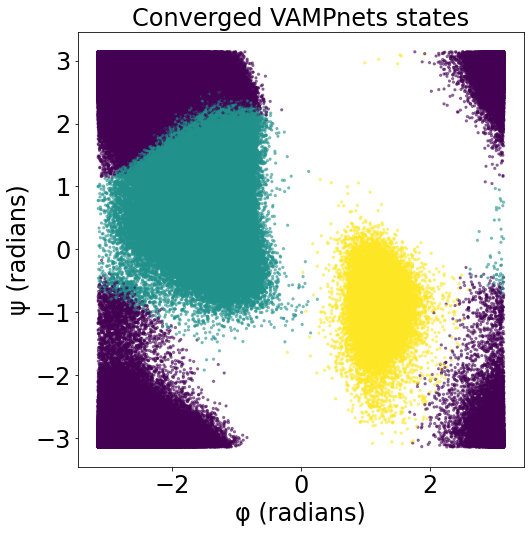

In [ ]:
#@title Step 7: Plot VAMPnets results
fig, ax = plt.subplots(figsize = (8,8))
state_probabilities = model.transform(traj)
assignments = state_probabilities.argmax(1)
ax.scatter(dihedrals[:, 0], dihedrals[:, 1], c=assignments, s=5, alpha=0.5)
ax.set_title('Converged VAMPnets states', fontsize = 24)
ax.set_xlabel('φ (radians)', fontsize = 24)
ax.set_ylabel('ψ (radians)', fontsize = 24)
ax.tick_params(axis='x', labelsize= 24)
ax.tick_params(axis='y', labelsize= 24)
#ax2.set_ylim(0, np.max(best_u_master)*1.3)
#ax.legend(loc='best', numpoints=1, fontsize=24)

In [ ]:
#@title Step 8: Calculate standard deviation (to perturb data)/circular and picka  point
import scipy.stats as sst
import random
import torch.nn.functional as F

random.seed(10)
np.random.seed(10)
num_samples = 2000
input_dim = traj.shape[1]


#print(IB.encode(torch.tensor(x_de).float()))
std = []
for i in range(dihedrals.shape[1]):
  std.append(sst.circstd(dihedrals[:,i]))


#state A
coord = [-1.2,2,0,np.pi-0.2]
#state B
#coord = [0,0,0,np.pi-0.2]
#state C
#coord = [2.2,-1,0,np.pi-0.2]
coord_8 = []
for i in range(4):
  coord_8.append(np.sin(coord[i]))
  coord_8.append(np.cos(coord[i]))

indices = []

norm_threshold = 0.2


def point_picker(x_0,data, norm_threshold):
  found = False
  while found == False:
    for i in range(data.shape[0]):
      condition = []
      for j in range(data.shape[1]):
        condition.append(True) if np.linalg.norm(data[i,j]-x_0[j]) < norm_threshold else condition.append(False)
      if all(condition) == True:
        return data[i,:],i
    norm_threshold *= 2
    print('Increasing threshold :' + str(norm_threshold))



x_0, x_0_index = point_picker(coord_8,traj, norm_threshold)
indices.append(x_0_index)

print(x_0)
print(x_0_index)
print(np.arctan2(x_0[0], x_0[1]), np.arctan2(x_0[2], x_0[3]), np.arctan2(x_0[4], x_0[5]), np.arctan2(x_0[6], x_0[7]), )

[-0.94970516  0.31314551  0.93869549 -0.3447474  -0.12061363  0.99269953
  0.24824842 -0.9686964 ]
161
-1.252293 1.922766 -0.12090800000000002 2.890721


In [ ]:
#@title Step 9: Generate Neighbourhood
seed= 0


num_samples = 5000
neighbourhood_master = []
assignments_master = []
data_master = []

fig2,ax2 = plt.subplots(1,2, figsize = (12,6))


np.random.seed(seed)
#############
neighbourhood_data = np.zeros((num_samples, 2*dihedrals.shape[1]))
perturb_or_not = np.random.randint(0, 2, num_samples * dihedrals.shape[1]).reshape((num_samples, dihedrals.shape[1]))

del_lst = []
for i in range(perturb_or_not.shape[0]):
  if np.sum(perturb_or_not[i,:]) == dihedrals.shape[1]:
    del_lst.append(i)

perturb_or_not = np.delete(perturb_or_not, del_lst, axis = 0)
neighbourhood_data = np.delete(neighbourhood_data, del_lst, axis = 0)
#######
#perturb_or_not = np.zeros((num_samples - len(del_lst), 10))
#######
perturb_or_not[0,:] = 1
print(perturb_or_not.shape)
########
for i in range(num_samples - len(del_lst)):
    for j in range(dihedrals.shape[1]):
        if perturb_or_not[i,j] == 1:
            neighbourhood_data[i,2*j] = traj[indices[0], 2*j]
            neighbourhood_data[i,2*j+1] = traj[indices[0], 2*j+1]
        elif perturb_or_not[i,j] == 0:
                ran_dat = np.random.normal(0, 1)*0.4
                neighbourhood_data[i,2*j] = ran_dat*std[j] + traj[indices[0],2*j]
                neighbourhood_data[i,2*j+1] = ran_dat*std[j] + traj[indices[0],2*j+1]
state_probabilities = model.transform(neighbourhood_data)
assignments = state_probabilities.argmax(1)

e = np.arctan2(neighbourhood_data[:,0], neighbourhood_data[:,1])
f = np.arctan2(neighbourhood_data[:,2], neighbourhood_data[:,3])
e2 = np.arctan2(neighbourhood_data[:,4], neighbourhood_data[:,5])
f2 = np.arctan2(neighbourhood_data[:,6], neighbourhood_data[:,7])
##########
ax2[0].plot(e,f,'o', markersize = 4, alpha = 0.4, markeredgecolor = 'k')
ax2[0].set_xlim(-np.pi, np.pi)
ax2[0].set_ylim(-np.pi, np.pi)
ax2[1].plot(e2,f2,'o', markersize = 4, alpha = 0.4, markeredgecolor = 'k')
ax2[1].set_xlim(-np.pi, np.pi)
ax2[1].set_ylim(-np.pi, np.pi)

ax2[0].set_title('Generated neighborhood', fontsize = 24)
ax2[0].set_xlabel('φ (radians)', fontsize = 24)
ax2[0].set_ylabel('ψ (radians)', fontsize = 24)
ax2[0].tick_params(axis='x', labelsize= 24)
ax2[0].tick_params(axis='y', labelsize= 24)

ax2[1].set_title('Generated neighborhood', fontsize = 24)
ax2[1].set_xlabel('φ (radians)', fontsize = 24)
ax2[1].set_ylabel('ψ (radians)', fontsize = 24)
ax2[1].tick_params(axis='x', labelsize= 24)
ax2[1].tick_params(axis='y', labelsize= 24)
##########
state_probabilities = model.transform(neighbourhood_data)
assignments = state_probabilities.argmax(1)
fig2.tight_layout()

Sigma grid/search space:  [1.00000000e-03 1.10452261e-02 2.10904523e-02 3.11356784e-02
 4.11809045e-02 5.12261307e-02 6.12713568e-02 7.13165829e-02
 8.13618090e-02 9.14070352e-02 1.01452261e-01 1.11497487e-01
 1.21542714e-01 1.31587940e-01 1.41633166e-01 1.51678392e-01
 1.61723618e-01 1.71768844e-01 1.81814070e-01 1.91859296e-01
 2.01904523e-01 2.11949749e-01 2.21994975e-01 2.32040201e-01
 2.42085427e-01 2.52130653e-01 2.62175879e-01 2.72221106e-01
 2.82266332e-01 2.92311558e-01 3.02356784e-01 3.12402010e-01
 3.22447236e-01 3.32492462e-01 3.42537688e-01 3.52582915e-01
 3.62628141e-01 3.72673367e-01 3.82718593e-01 3.92763819e-01
 4.02809045e-01 4.12854271e-01 4.22899497e-01 4.32944724e-01
 4.42989950e-01 4.53035176e-01 4.63080402e-01 4.73125628e-01
 4.83170854e-01 4.93216080e-01 5.03261307e-01 5.13306533e-01
 5.23351759e-01 5.33396985e-01 5.43442211e-01 5.53487437e-01
 5.63532663e-01 5.73577889e-01 5.83623116e-01 5.93668342e-01
 6.03713568e-01 6.13758794e-01 6.23804020e-01 6.33849246e-0

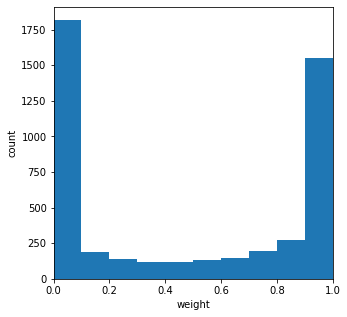

In [ ]:
#@title Step 7: Assign similarity kernel from representative distance through grid search and visualize distribution (grid_start should be >0, else nan)
grid_start = 0.001 #@param {type:"number"}
grid_end = 2 #@param {type:"number"}
num_grids = 200 #@param {type:"integer"}
#print(dd)
import sklearn.metrics as met
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
data = neighbourhood_data
distance_metric='cosine'

def distances_f(data):
    return met.pairwise_distances(data,data[0].reshape(1, -1),metric=distance_metric).ravel()

def kernel(d, kernel_width):
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

distances = distances_f(data)

def ret_weights(distances, kernel_width):
  weights = np.zeros((distances.shape[0]))
  for ik in range(distances.shape[0]):
      weights[ik] = kernel(distances[ik], kernel_width)
  return weights

from sklearn import metrics
bb = np.linspace(grid_start, grid_end, num_grids)
bb_eval = []
bb_std = []
for i in range(bb.shape[0]):
  weights = ret_weights(distances, bb[i])
  bb_std.append(np.std(weights))
########
optimal_bb_index = np.argmax(bb_std)
weights = ret_weights(distances, bb[optimal_bb_index])
#weights = ret_weights(distances, 0.02)
#########
fig2, ax2 = plt.subplots(figsize = (5,5))
ax2.hist(weights, bins = 10)
ax2.set_ylabel('count')
ax2.set_xlabel('weight')
ax2.set_xlim(0,1)
print("Sigma grid/search space: ", bb)
print("Optimal sigma: ", bb[optimal_bb_index])
print('Highest std: ', bb_std[optimal_bb_index])

In [ ]:
wok = x_0
s_probabilities = model.transform(np.array(wok).reshape(1,-1))
ass = s_probabilities.argmax(1)
print(ass)

[0]


In [ ]:
print(assignments)
a = np.zeros((assignments.shape[0]),dtype = 'int')
for i in range(assignments.shape[0]):
  if assignments[i] == ass[0]:
    a[i] = 1

[0 0 2 ... 0 1 0]


[1 1 0 ... 1 0 1]


(array([1165.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3506.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

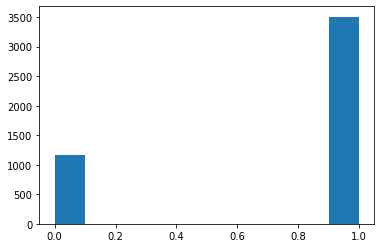

In [ ]:
print(a)
plt.hist(a)

0: , k = 1
500: , k = 1
1000: , k = 1
1500: , k = 1
2000: , k = 1
2500: , k = 1
3000: , k = 1
3500: , k = 1
4000: , k = 1
4500: , k = 1
5000: , k = 1
5500: , k = 1
6000: , k = 1
6500: , k = 1
7000: , k = 1
7500: , k = 1
8000: , k = 1
8500: , k = 1
9000: , k = 1
9500: , k = 1
10000: , k = 1
10500: , k = 1
11000: , k = 1
11500: , k = 1
12000: , k = 1
12500: , k = 1
13000: , k = 1
13500: , k = 1
14000: , k = 1
14500: , k = 1
15000: , k = 1
15500: , k = 1
16000: , k = 1
16500: , k = 1
17000: , k = 1
17500: , k = 1
18000: , k = 1
18500: , k = 1
19000: , k = 1
19500: , k = 1
20000: , k = 1
20500: , k = 1
21000: , k = 1
21500: , k = 1
22000: , k = 1
22500: , k = 1
23000: , k = 1
23500: , k = 1
24000: , k = 1
24500: , k = 1
25000: , k = 1
25500: , k = 1
26000: , k = 1
26500: , k = 1
27000: , k = 1
27500: , k = 1
28000: , k = 1
28500: , k = 1
29000: , k = 1
29500: , k = 1
30000: , k = 1
30500: , k = 1
31000: , k = 1
31500: , k = 1
32000: , k = 1
32500: , k = 1
33000: , k = 1
33500: , k = 1
3400

No handles with labels found to put in legend.


k =  1
8643 8720 32637
[0.65673197 0.         0.         0.        ] -0.6716760237248623
Best unfaithfulness:  0.06425493817874744
0: , k = 2
500: , k = 2
1000: , k = 2
1500: , k = 2
2000: , k = 2
2500: , k = 2
3000: , k = 2
3500: , k = 2
4000: , k = 2
4500: , k = 2
5000: , k = 2
5500: , k = 2
6000: , k = 2
6500: , k = 2
7000: , k = 2
7500: , k = 2
8000: , k = 2
8500: , k = 2
9000: , k = 2
9500: , k = 2
10000: , k = 2
10500: , k = 2
11000: , k = 2
11500: , k = 2
12000: , k = 2
12500: , k = 2
13000: , k = 2
13500: , k = 2
14000: , k = 2
14500: , k = 2
15000: , k = 2
15500: , k = 2
16000: , k = 2
16500: , k = 2
17000: , k = 2
17500: , k = 2
18000: , k = 2
18500: , k = 2
19000: , k = 2
19500: , k = 2
20000: , k = 2
20500: , k = 2
21000: , k = 2
21500: , k = 2
22000: , k = 2
22500: , k = 2
23000: , k = 2
23500: , k = 2
24000: , k = 2
24500: , k = 2
25000: , k = 2
25500: , k = 2
26000: , k = 2
26500: , k = 2
27000: , k = 2
27500: , k = 2
28000: , k = 2
28500: , k = 2
29000: , k = 2
29500: ,

No handles with labels found to put in legend.


k =  2
6642 6588 36770
[1.71826475 0.         0.2931768  0.        ] -3.297536357274358
Best unfaithfulness:  0.04947177647856248
0: , k = 3
500: , k = 3
1000: , k = 3
1500: , k = 3
2000: , k = 3
2500: , k = 3
3000: , k = 3
3500: , k = 3
4000: , k = 3
4500: , k = 3
5000: , k = 3
5500: , k = 3
6000: , k = 3
6500: , k = 3
7000: , k = 3
7500: , k = 3
8000: , k = 3
8500: , k = 3
9000: , k = 3
9500: , k = 3
10000: , k = 3
10500: , k = 3
11000: , k = 3
11500: , k = 3
12000: , k = 3
12500: , k = 3
13000: , k = 3
13500: , k = 3
14000: , k = 3
14500: , k = 3
15000: , k = 3
15500: , k = 3
16000: , k = 3
16500: , k = 3
17000: , k = 3
17500: , k = 3
18000: , k = 3
18500: , k = 3
19000: , k = 3
19500: , k = 3
20000: , k = 3
20500: , k = 3
21000: , k = 3
21500: , k = 3
22000: , k = 3
22500: , k = 3
23000: , k = 3
23500: , k = 3
24000: , k = 3
24500: , k = 3
25000: , k = 3
25500: , k = 3
26000: , k = 3
26500: , k = 3
27000: , k = 3
27500: , k = 3
28000: , k = 3
28500: , k = 3
29000: , k = 3
29500: , 

No handles with labels found to put in legend.


k =  3
4204 4276 41520
[1.71826475e+00 0.00000000e+00 2.93176798e-01 1.00000000e-13] -3.297536357274358
Best unfaithfulness:  0.04947177647855797
0: , k = 4
500: , k = 4
1000: , k = 4
1500: , k = 4
2000: , k = 4
2500: , k = 4
3000: , k = 4
3500: , k = 4
4000: , k = 4
4500: , k = 4
5000: , k = 4
5500: , k = 4
6000: , k = 4
6500: , k = 4
7000: , k = 4
7500: , k = 4
8000: , k = 4
8500: , k = 4
9000: , k = 4
9500: , k = 4
10000: , k = 4
10500: , k = 4
11000: , k = 4
11500: , k = 4
12000: , k = 4
12500: , k = 4
13000: , k = 4
13500: , k = 4
14000: , k = 4
14500: , k = 4
15000: , k = 4
15500: , k = 4
16000: , k = 4
16500: , k = 4
17000: , k = 4
17500: , k = 4
18000: , k = 4
18500: , k = 4
19000: , k = 4
19500: , k = 4
20000: , k = 4
20500: , k = 4
21000: , k = 4
21500: , k = 4
22000: , k = 4
22500: , k = 4
23000: , k = 4
23500: , k = 4
24000: , k = 4
24500: , k = 4
25000: , k = 4
25500: , k = 4
26000: , k = 4
26500: , k = 4
27000: , k = 4
27500: , k = 4
28000: , k = 4
28500: , k = 4
29000: ,

No handles with labels found to put in legend.


k =  4
3329 3359 43312
[1.71826475e+00 1.00000000e-13 2.93176798e-01 1.00000000e-13] -3.297536357274358
Best unfaithfulness:  0.049471776478557244


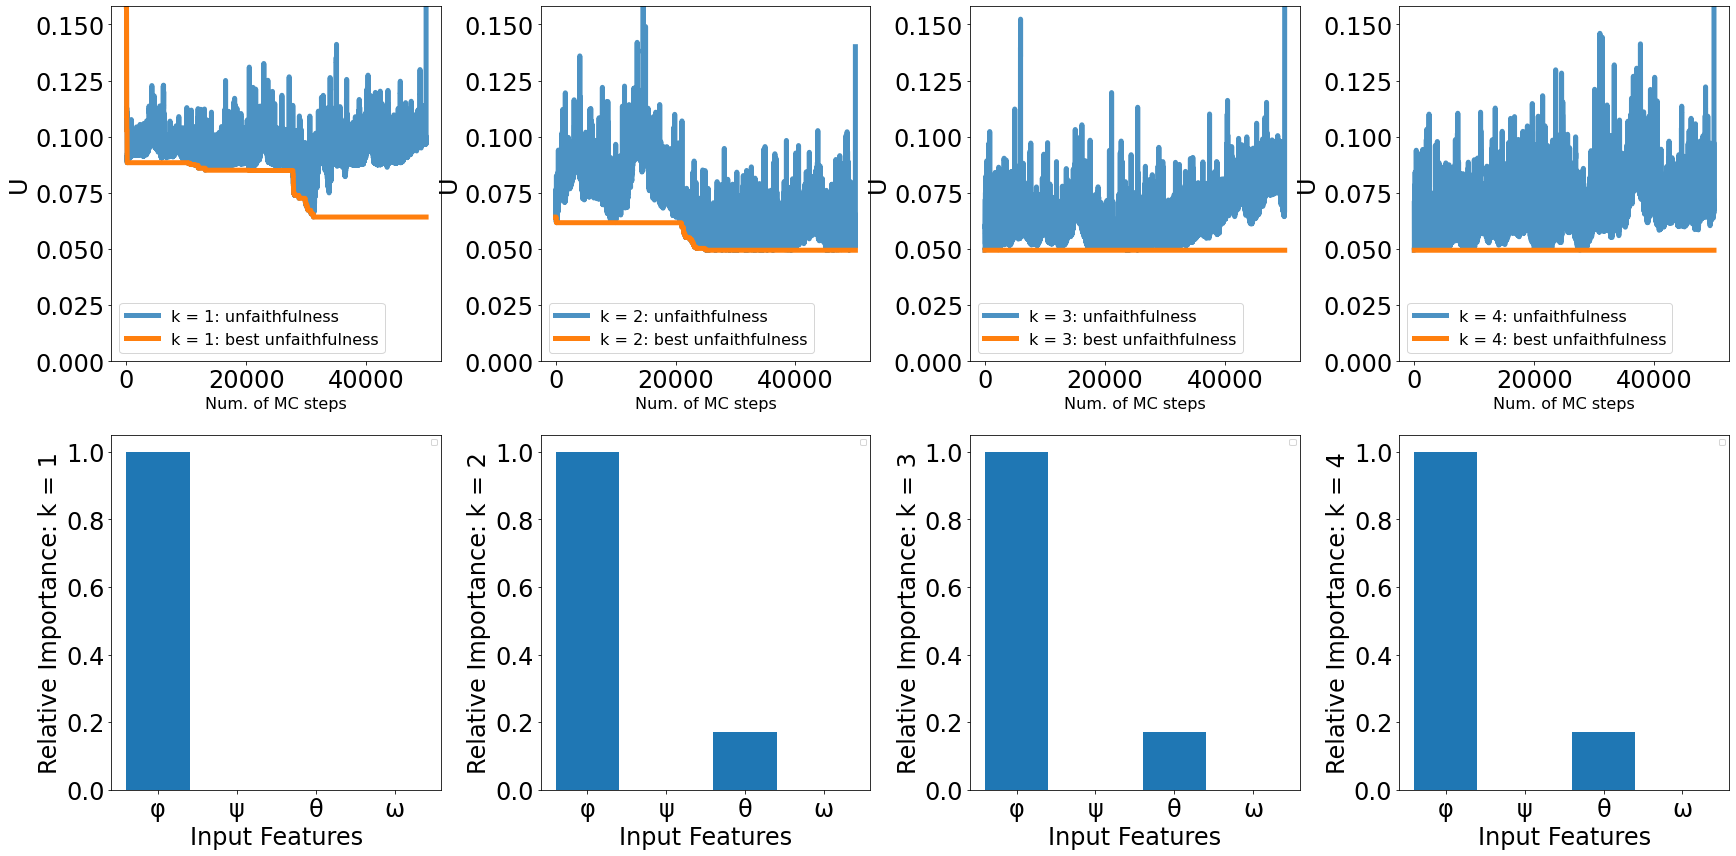

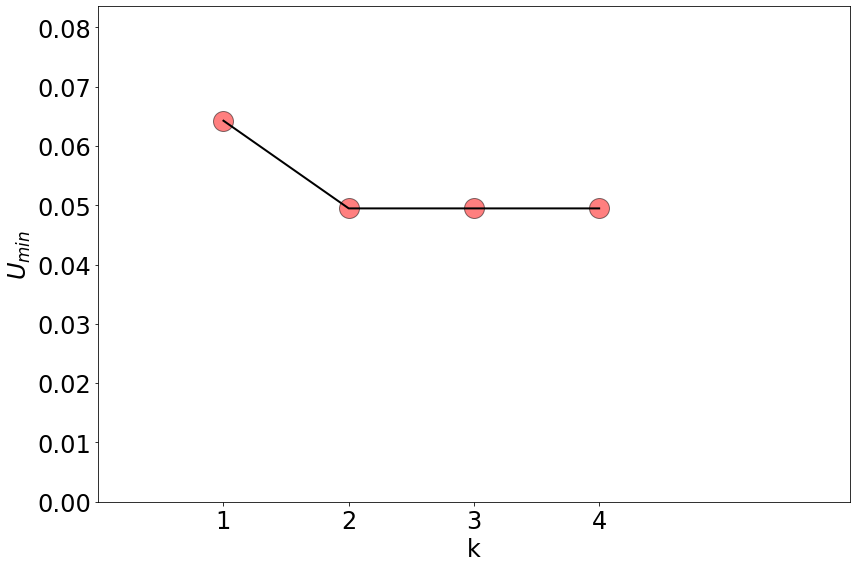

In [ ]:
#@title Step 8: Commence TERP!
MC_iterations = 50000 #@param {type:"integer"}
metropolis_param = 10 #@param {type:"number"}
MC_detailed_report = "yes" #@param {type:"string"}
k_max = 4 #@param {type:"integer"}
seed = 0 #@param {type:"integer"}

stacked = np.column_stack((e,f,e2,f2))
#for i in range(stacked.shape[0]):
#  if stacked[i,3]<0:
#    stacked[i,3] += np.pi
#  else:
#    stacked[i,3] -= np.pi

neighbourhood_data = stacked
labels_collapsed = a

############
import copy
import pdb
import random
#smaller T, more MC jumps
T = metropolis_param
iterations = MC_iterations
seed = seed
calc_clip = k_max


N = neighbourhood_data.shape[1]
k_array = np.arange(calc_clip)+1
random.seed(seed)
np.random.seed(seed)

def weighted_local_model_value(data, weights, coefficient_array, intercept):
    local_model_mat = np.zeros((data.shape[0], data.shape[1]))
    for i in range(data.shape[1]):
      local_model_mat[:,i] = data[:,i] * coefficient_array[i]
    matrix = np.sum(local_model_mat, axis = 1) + intercept
    weighted_matrix = np.multiply(np.sqrt(weights), matrix)
    return weighted_matrix

def unfaithfulness_calc(k, N, neighbourhood_data, labels, weights, T, iterations, inherit, inheritance_values):
  tot_weight = np.sum(weights)
  k_random_draws = np.random.choice(np.arange(N),size = k, replace = False)
  weighted_obscure_model_pred = np.multiply(np.sqrt(weights), labels)
  
  coefficient_array = np.zeros((iterations + 1, N))
  intercept_array = np.zeros((iterations + 1))

  unfaithfulness = np.zeros((iterations + 1))
  best_unfaithfulness = np.zeros((iterations + 1))

  # Initialization
  intercept_array[0] = 1
  for i in range(k):
    coefficient_array[0, k_random_draws[i]] = 1

  # Initialization with inheritance
  if inherit == 'yes':
    coefficient_array[0, :] = inheritance_values[0]
    intercept_array[0] = inheritance_values[1]

    inherited_nonzero = np.nonzero(coefficient_array[0, :])[0]
    zeros_to_perturb =  k - inherited_nonzero.shape[0]
    inherited_zero = np.where(coefficient_array[0, :] == 0)[0]
    needed_random_draws = np.random.choice(inherited_zero, size = zeros_to_perturb, replace = False)

    for j in range(k_random_draws.shape[0] - zeros_to_perturb):
      k_random_draws[j] = inherited_nonzero[j]
    for j in range(needed_random_draws.shape[0]):
      k_random_draws[-j] = needed_random_draws[j]
      coefficient_array[0, k_random_draws[-j]] = 0.0000000000001



  
  #pdb. set_trace()
  # Setup counters
  total_accepted_count = 0
  metropolis_accepted_count = 0
  rejected_count = 0

  current_step = 0
  while current_step < iterations :
    R = np.random.uniform(low=0.0, high = 1.0)

    local_model_pred = weighted_local_model_value(neighbourhood_data, weights, coefficient_array[current_step, :], intercept_array[current_step])
    weighted_residual_matrix = (weighted_obscure_model_pred-local_model_pred)**2
    #wo_sum = 0
    #for wo in range(coefficient_array.shape[1]):
    #  wo_sum += coefficient_array[current_step, wo]**2
    unfaithfulness[current_step] = np.sum(weighted_residual_matrix)#+0.1*wo_sum

    if current_step == 0:
      best_unfaithfulness[0] = unfaithfulness[0]

    nonzero_coefficient_indices = np.nonzero(coefficient_array[current_step, :])[0]
    assert len(nonzero_coefficient_indices) == k

    q = np.random.uniform(low = -0.5, high = 0.5, size = k+1)/10
    for i in range(len(nonzero_coefficient_indices)):
      coefficient_array[current_step + 1, nonzero_coefficient_indices[i]] = coefficient_array[current_step, nonzero_coefficient_indices[i]] + q[i]
      intercept_array[current_step + 1] = intercept_array[current_step] + q[k]
    ## Swap coefficients using tuple unpacking
    p = np.random.choice(np.arange(N),size = 1, replace = True)
    p2 = np.random.choice(np.arange(len(nonzero_coefficient_indices)),size = 1, replace = True)
    coefficient_array[current_step + 1, k_random_draws[p2]], coefficient_array[current_step + 1, p] = coefficient_array[current_step + 1, p], coefficient_array[current_step + 1, k_random_draws[p2]]

    updated_local_model_pred = weighted_local_model_value(neighbourhood_data, weights, coefficient_array[current_step + 1, :], intercept_array[current_step + 1])
    updated_weighted_residual_matrix = (weighted_obscure_model_pred-updated_local_model_pred)**2

    unfaithfulness[current_step + 1] = np.sum(updated_weighted_residual_matrix)

    if unfaithfulness[current_step + 1] < unfaithfulness[current_step]:
      ## Keep the updates
      best_unfaithfulness[current_step + 1 ] = np.min(unfaithfulness[:current_step + 2])
      total_accepted_count += 1
    elif np.exp(-(np.sum(updated_weighted_residual_matrix)-np.sum(weighted_residual_matrix))/(np.sqrt(k+1)*T)) > R:
      ## Keep the updates
      best_unfaithfulness[current_step + 1 ] = np.min(unfaithfulness[:current_step + 2])
      metropolis_accepted_count += 1
    else:
      coefficient_array[current_step + 1, :] = coefficient_array[current_step, :]
      intercept_array[current_step + 1] = intercept_array[current_step]
      best_unfaithfulness[current_step + 1 ] = np.min(unfaithfulness[:current_step + 2])
      rejected_count += 1
    
    if current_step%500 ==0:
        print(str(current_step) + ': , k = ' + str(k))
    current_step += 1
  print('k = ', k)
  print(total_accepted_count, metropolis_accepted_count, rejected_count)
  if inherit == "no":
    return coefficient_array, intercept_array, unfaithfulness/tot_weight, best_unfaithfulness/tot_weight
  elif best_unfaithfulness[-1]/tot_weight < best_u_master[k-2]:
    return coefficient_array, intercept_array, unfaithfulness/tot_weight, best_unfaithfulness/tot_weight
  else:
    print("No improvement at k = ", k, "Adding coefficients, intercept, last iteration value of best unfaithfulness from (k-1) values!")
    ## in the indices below used -2 instead of -1 because here k starts from 1, while list indices start from 0
    coefficient_array = np.vstack((coefficient_array, best_coefficients[k-2]))
    intercept_array = np.append(intercept_array, best_intercepts[k-2])
    unfaithfulness = np.append(unfaithfulness, best_u_master[k-2]*tot_weight)
    best_unfaithfulness = np.append(best_unfaithfulness, best_u_master[k-2]*tot_weight)
    return coefficient_array, intercept_array, unfaithfulness/tot_weight, best_unfaithfulness/tot_weight


worse_u_master = []
best_u_master = []
best_coefficients = []
best_intercepts = []

if MC_detailed_report == 'yes':
  fig, ax = plt.subplots(2, calc_clip, figsize = (6*calc_clip, 6*2))
inherit = "no"
inheritance_values = 'null'
for k in k_array:
  coefficient_array, intercept_array, unfaithfulness, best_unfaithfulness = unfaithfulness_calc(k,N, neighbourhood_data, labels_collapsed, weights, T, iterations, inherit, inheritance_values)
  
  if MC_detailed_report == 'yes':
    ax[0, k-1].plot(unfaithfulness, linewidth = 5, alpha = 0.8, label = 'k = ' + str(k) + ': unfaithfulness')
    ax[0, k-1].plot(best_unfaithfulness, linewidth = 5, alpha = 1.0, label = 'k = ' + str(k) + ': best unfaithfulness')

  

  best_model_index = np.where(unfaithfulness == best_unfaithfulness[-1])[0][0]
  print(coefficient_array[best_model_index, :], intercept_array[best_model_index])
  best_coefficients.append(coefficient_array[best_model_index, :])
  best_intercepts.append(intercept_array[best_model_index])
  inheritance_values = [coefficient_array[best_model_index, :], intercept_array[best_model_index]]
  inherit = 'yes'

  assert best_unfaithfulness[-1] == np.min(unfaithfulness)
  print("Best unfaithfulness: ", unfaithfulness[best_model_index])
  best_u_master.append(best_unfaithfulness[-1])
  worse_u_master.append(np.max(best_unfaithfulness))
  abs_val = np.absolute(coefficient_array[best_model_index, :])

  if MC_detailed_report == 'yes':
    ax[1, k-1].bar(np.arange(abs_val.shape[0]), abs_val/np.max(abs_val) )
    ax[1, k-1].set_xticks(np.arange(4))
    ax[1, k-1].set_xticklabels(['φ', 'ψ', 'θ', 'ω'])

    ax[0, k-1].set_xlabel('Num. of MC steps', fontsize = 16)
    ax[0, k-1].tick_params(axis='x', labelsize= 24)
    ax[0, k-1].set_ylabel('U', fontsize = 24)
    ax[0, k-1].tick_params(axis='y', labelsize= 24)
    ax[0, k-1].legend(loc="best", numpoints=1, fontsize=16)
    ax[1, k-1].set_xlabel('Input Features', fontsize = 24)
    ax[1, k-1].tick_params(axis='x', labelsize= 24)
    ax[1, k-1].set_ylabel('Relative Importance: k = ' + str(k), fontsize = 24)
    ax[1, k-1].tick_params(axis='y', labelsize= 24)
    ax[1, k-1].legend(loc="best", numpoints=1, fontsize=8)

if MC_detailed_report == 'yes':
  for k in k_array:
    ax[0, k-1].set_ylim(0, np.max(worse_u_master))
  fig.tight_layout()
  fig2, ax2 = plt.subplots(figsize = (12,8))
  ax2.plot(best_u_master, 'o', markersize = 20, markeredgecolor = 'k', color = 'red', alpha = 0.5)
  ax2.plot(best_u_master, color = 'k', linewidth = 2)
  ax2.set_xlabel('k', fontsize = 24)
  ax2.set_xticks(np.arange(N))
  ax2.set_xticklabels(np.arange(N)+1)
  ax2.tick_params(axis='x', labelsize= 24)
  ax2.set_ylabel(r'$U_{min}$', fontsize = 24)
  ax2.tick_params(axis='y', labelsize= 24)
  ax2.set_ylim(0, np.max(best_u_master)*1.3)
  ax2.set_xlim(-1,calc_clip+1)
  fig2.tight_layout()
################
################




In [ ]:
u0_unfaithfulness = np.zeros((iterations + 1))
u0_best_unfaithfulness = np.zeros((iterations + 1))

# Initialization
intercept_array[0] = 1

# Setup counters
total_accepted_count = 0
metropolis_accepted_count = 0
rejected_count = 0


def u0_weighted_local_model_value(weights, intercept):
    weighted_matrix = np.sqrt(weights)* intercept
    return weighted_matrix

current_step = 0
while current_step < iterations :
  R = np.random.uniform(low=0.0, high = 1.0)

  local_model_pred = u0_weighted_local_model_value(weights, intercept_array[current_step])
  weighted_obscure_model_pred = np.multiply(np.sqrt(weights), labels_collapsed)
  weighted_residual_matrix = (weighted_obscure_model_pred-local_model_pred)**2

  u0_unfaithfulness[current_step] = np.sum(weighted_residual_matrix)
  if current_step == 0:
    u0_best_unfaithfulness[0] = u0_unfaithfulness[0]

  q = np.random.uniform(low = -0.5, high = 0.5, size = 1)/10
  intercept_array[current_step + 1] = intercept_array[current_step] + q

  updated_local_model_pred = u0_weighted_local_model_value(weights, intercept_array[current_step + 1])
  updated_weighted_residual_matrix = (weighted_obscure_model_pred-updated_local_model_pred)**2

  u0_unfaithfulness[current_step + 1] = np.sum(updated_weighted_residual_matrix)

  if u0_unfaithfulness[current_step + 1] < u0_unfaithfulness[current_step]:
    ## Keep the updates
    u0_best_unfaithfulness[current_step + 1 ] = np.min(u0_unfaithfulness[:current_step + 2])
    total_accepted_count += 1

  else:
    intercept_array[current_step + 1] = intercept_array[current_step]
    u0_best_unfaithfulness[current_step + 1 ] = np.min(u0_unfaithfulness[:current_step + 2])
    rejected_count += 1

  current_step += 1

In [ ]:
best_u_master_2 =  [u0_best_unfaithfulness[-1]/np.sum(weights)] + best_u_master
print(best_u_master_2)

[0.0874739565238883, 0.06425493817874744, 0.04947177647856248, 0.04947177647855797, 0.049471776478557244]


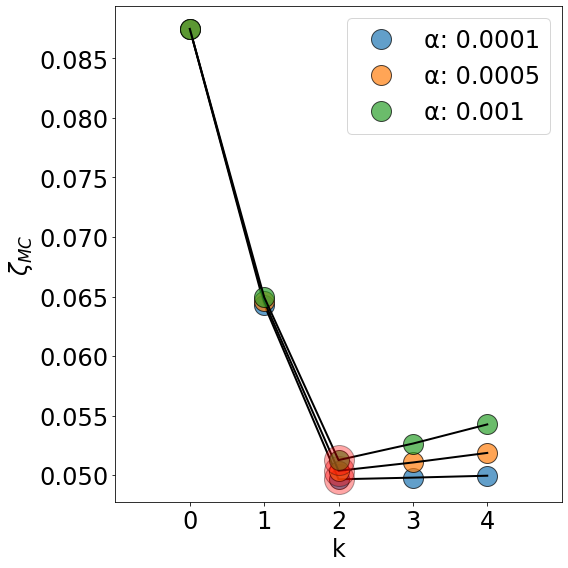

In [ ]:
#@title Step 10: plot ζ and dζ/dk

##### Added (+1) inside factorial
alpha_01 =  0.0001#@param {type:"number"}
alpha_02 =  0.0005#@param {type:"number"}
alpha_03 =  0.001#@param {type:"number"}

fig2, ax2 = plt.subplots(figsize = (8,8))

N = calc_clip
#alpha = [0, 0.0005, 0.0025]
alpha = [alpha_01, alpha_02, alpha_03]
def zeta(u, alpha):
    tem = []
    for jj in range(len(u)):
        tem.append(u[jj] + alpha*np.log(np.math.factorial(jj+1)))
        
    return tem

zeta_master = []
for i in range(len(alpha)):
    zet = zeta(best_u_master_2, alpha[i])
    ax2.plot(zet, 'o', markersize = 20, markeredgecolor = 'k', alpha = 0.7, label = 'α: ' + str(alpha[i]))
    ax2.plot(zet, color = 'k', linewidth = 2)
    zeta_master.append(zet)

    if alpha[i] ==0:
      print(zet)

    gg = np.argmin(zet)
    hh = np.min(zet)
    ax2.plot(gg,hh, 'o', markersize  = 30, color = 'red', alpha = 0.35, markeredgecolor = 'k')
    ########
    f = zet
    ds = []
    #print(f)
    #for pp in range(len(zet)-1):
    #    ds.append(zet[pp+1]-zet[pp])
    #d2s = np.gradient(ds)
    #print(ds)
    #ax2[1].plot(ds, 'o', markersize = 20, markeredgecolor = 'k', alpha = 0.5, label = 'α: ' + str(alpha[i]))
    #ax2[1].plot(ds, color = 'k', linewidth = 2)
    #ax4.plot(d2s, 'o', markersize = 20, markeredgecolor = 'k', alpha = 0.5, label = 'α: ' + str(alpha[i]))
    #ax4.plot(d2s, color = 'k', linewidth = 2)

    
    #ax2[1].set_xlabel('k', fontsize = 24)
    #ax2[1].set_xticks(np.arange(N))
    #ax2[1].set_xticklabels(np.arange(N)+1)
    #ax2[1].tick_params(axis='x', labelsize= 24)
    #ax2[1].set_ylabel('', fontsize = 24)
    #ax2[1].tick_params(axis='y', labelsize= 24)
    #ax.set_xlim(-2,11)
    #ax.set_ylim(-20, 1)



    #####
    #ax4.set_xlabel('k', fontsize = 24)
    #ax4.set_xticks(np.arange(N))
    #ax4.set_xticklabels(np.arange(N)+1)
    #ax4.tick_params(axis='x', labelsize= 24)
    #ax4.set_ylabel('', fontsize = 24)
    #ax4.tick_params(axis='y', labelsize= 24)
    #ax.set_xlim(-2,11)
    #ax.set_ylim(-20, 1)
    ########
ax2.set_xlabel('k', fontsize = 24)
ax2.set_xticks(np.arange(N+1))
ax2.set_xticklabels(np.arange(N+1))
ax2.tick_params(axis='x', labelsize= 24)
ax2.set_ylabel('$ζ_{MC}$', fontsize = 24)
ax2.tick_params(axis='y', labelsize= 24)
#ax2.set_ylim(0, np.max(best_u_master)*1.3)
ax2.legend(loc='best', numpoints=1, fontsize=24)
ax2.set_xlim(-1,calc_clip+1)




#ax2[1].set_xlabel('k', fontsize = 24)
#ax2[1].set_xticks(np.arange(N))
#ax2[1].set_xticklabels(np.arange(N)+1)
#ax2[1].tick_params(axis='x', labelsize= 24)
#ax2[1].set_ylabel('$dζ/dk$', fontsize = 24)
#ax2[1].tick_params(axis='y', labelsize= 24)
#ax3.set_ylim(0, np.max(best_u_master)*1.3)
#ax2[1].legend(loc="best", numpoints=1, fontsize=24)
#ax2[1].set_xlim(-1,calc_clip+1)
#ax3.set_ylim(-0.1,0.3)
fig2.tight_layout()


#ax4.set_xlabel('k', fontsize = 24)
#ax4.set_xticks(np.arange(N))
#ax4.set_xticklabels(np.arange(N)+1)
#ax4.tick_params(axis='x', labelsize= 24)
#ax4.set_ylabel('$d^{2}ζ/dk^2$', fontsize = 24)
#ax4.tick_params(axis='y', labelsize= 24)
#ax4.set_ylim(0, np.max(best_u_master)*1.3)
#ax4.legend(loc="best", numpoints=1, fontsize=24)
#ax4.set_ylim(-0.01,0.05)
#fig4.tight_layout()

In [ ]:
#best_u_master_3 = []
best_u_master_3.append(zet)
print(best_u_master_3)

#best_u_master_4 = []
best_u_master_4.append(best_u_master_2)
print(best_u_master_4)

[[0.01260886225976875, 0.011317853066391697, 0.012302566621735083, 0.01367950722803215, 0.015288797835048969], [0.0637637186943077, 0.0637510885479888, 0.05096706868129182, 0.05122646657983604, 0.052824044797385214], [0.0874739565238883, 0.06494808535930739, 0.05126353594779054, 0.052649830308905916, 0.054259268221339294]]
[[0.01260886225976875, 0.010624705885831752, 0.010510807152507028, 0.010501453397684204, 0.010501306092266923], [0.0637637186943077, 0.06305794136742886, 0.04917530921206376, 0.048048412749488095, 0.048036553054603165], [0.0874739565238883, 0.06425493817874744, 0.04947177647856248, 0.04947177647855797, 0.049471776478557244]]


(-1.0, 5.0)

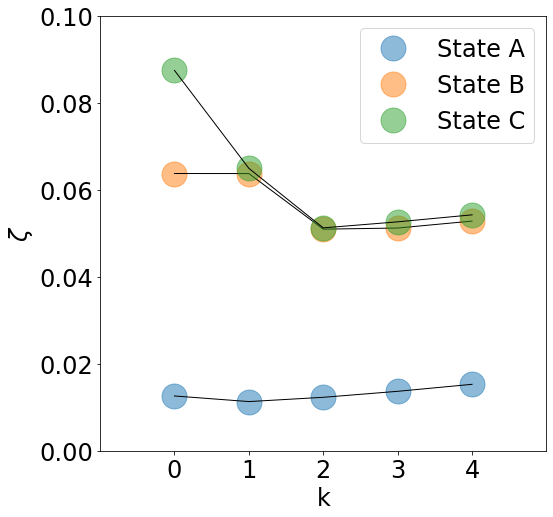

In [ ]:
#alpha = 0.001
fig, ax2 = plt.subplots(figsize = (8,8))
dic = ['A', 'B', 'C']
for i in range(3):
  ax2.plot(best_u_master_3[i], 'o', markersize = 25, alpha = 0.5, label = 'State ' + dic[i])
  ax2.plot(best_u_master_3[i], linewidth = 1, color = 'k')

ax2.set_xlabel('k', fontsize = 24)
ax2.set_xticks(np.arange(N+1))
ax2.set_xticklabels(np.arange(N+1))
ax2.tick_params(axis='x', labelsize= 24)
ax2.set_ylabel('$ζ$', fontsize = 24)
ax2.tick_params(axis='y', labelsize= 24)
ax2.set_ylim(0, 0.1)
ax2.legend(loc='best', numpoints=1, fontsize=24)
ax2.set_xlim(-1,calc_clip+1)

  0%|          | 0/99 [00:00<?, ?it/s]

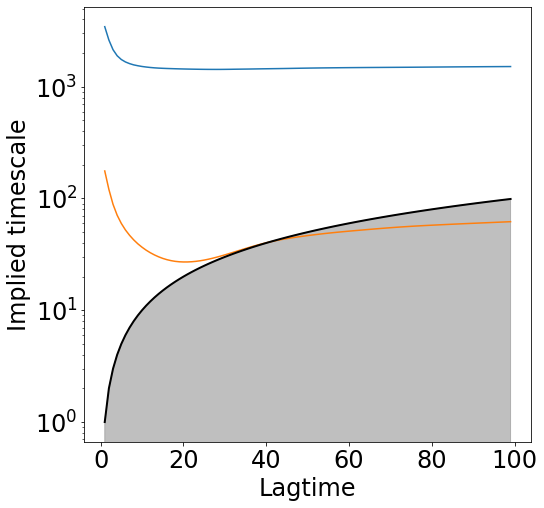

In [ ]:
######
from deeptime.decomposition import VAMP
from deeptime.util.validation import implied_timescales, ck_test
from deeptime.plots import plot_implied_timescales, plot_ck_test

lagtimes = np.arange(1, 100, dtype=np.int32)
vamp_models = [VAMP(lagtime=lag, observable_transform=model).fit_fetch(traj) for lag in tqdm(lagtimes)]

fig,ax = plt.subplots(figsize = (8,8))
ax = plot_implied_timescales(implied_timescales(vamp_models))
ax.set_yscale('log')
ax.set_xlabel('Lagtime', fontsize = 24)
ax.set_ylabel('Implied timescale', fontsize = 24)
ax.tick_params(axis='x', labelsize= 24)
ax.tick_params(axis='y', labelsize= 24)
#ax2.legend(loc='best', numpoints=1, fontsize=24)
#ax2.set_xlim(-1,calc_clip+1)